In [1]:
import sys; sys.path.insert(0, '../'); from lib.__init__ import *

*** THIS NOTEBOOK CAN BE USED TO ANALYSE RAW AND DEC OP.WVFs FROM LARSOFT ***

In [2]:
def convert_sampling_rate(wvf, sampling_rate, new_sampling_rate):
    time = np.arange(0, len(wvf), 1) / sampling_rate
    new_time = np.arange(0, len(wvf), 1) / new_sampling_rate
    new_wvf = np.interp(new_time, time, wvf)
    return new_wvf

ciemat_template_dict_list = []
this_wvf = []
# ciemat_template_dict = {}
ciemat_templates_model = os.listdir("../template/CIEMAT")
# print(ciemat_templates_model)
for model in ciemat_templates_model:
    # print("Loading model: {}".format(model))
    ciemat_templates = os.listdir("../template/CIEMAT/"+model+"/")
    for ciemat_template in ciemat_templates:
        if "Laser" in ciemat_template:
            wvf_type = "LASER"
        if "SPE" in ciemat_template:
            wvf_type = "SPE"
        if "OV1" in ciemat_template:
            ov = 1
        if "OV2" in ciemat_template:
            ov = 2
        if "OV3" in ciemat_template:
            ov = 3
        
        # print("Loading template: {}".format(ciemat_template))
        if ".npz" in ciemat_template:
            short_wvf = np.load("../template/CIEMAT/"+model+"/"+ciemat_template, allow_pickle=True)["arr_0"][0]
            # print(this_wvf)

        if ".root" in ciemat_template:
            root_file = uproot.open("../template/CIEMAT/"+model+"/"+ciemat_template)
            short_wvf = root_file[root_file.keys()[0]].to_numpy()[0]
            # print(this_wvf)
            
        if len(short_wvf) < len(this_wvf):
            this_wvf = np.concatenate((short_wvf,np.zeros(len(this_wvf)-len(short_wvf))))
            max_length = len(this_wvf)
        else:
            this_wvf = short_wvf
            max_length = len(this_wvf)
            # print(len(this_wvf))
        if np.argmax(this_wvf) != 200:
            this_wvf = np.roll(this_wvf,200-np.argmax(this_wvf))
            
        this_wvf = convert_sampling_rate(this_wvf, 1/4e9, 1/16e9)
        
        ciemat_template_dict = {"INST": "CIEMAT",
                                "NAME": ciemat_template,
                                "MODEL": model,
                                "OV": ov,
                                "AMP": np.max(this_wvf),
                                "TYPE": wvf_type,
                                "ADC":  this_wvf.tolist(),
                                "TIME": 16e-9*np.arange(len(this_wvf))}
        ciemat_template_dict_list.append(ciemat_template_dict)

# print(ciemat_template_dict)

NameError: name 'short_wvf' is not defined

/home/smanthey/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/smanthey/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


0

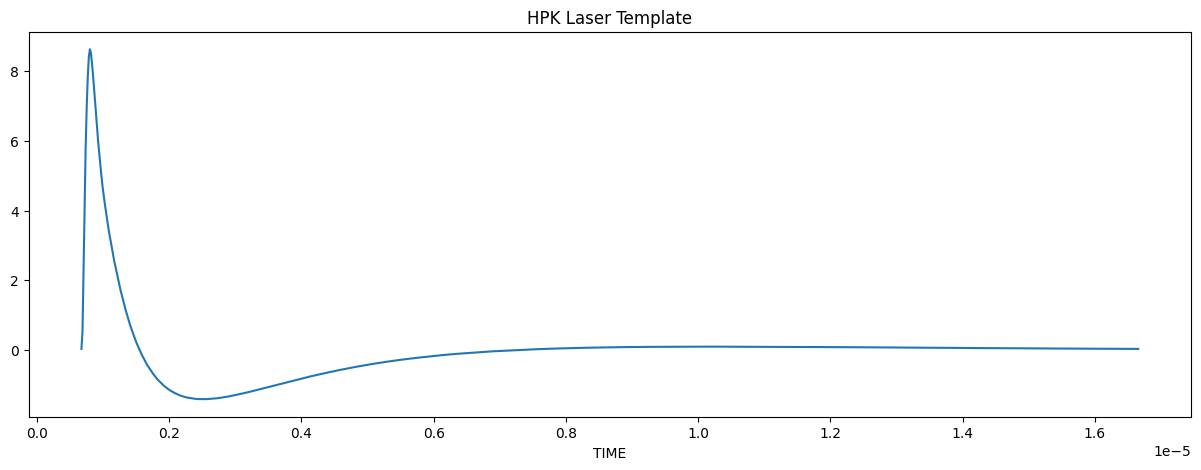

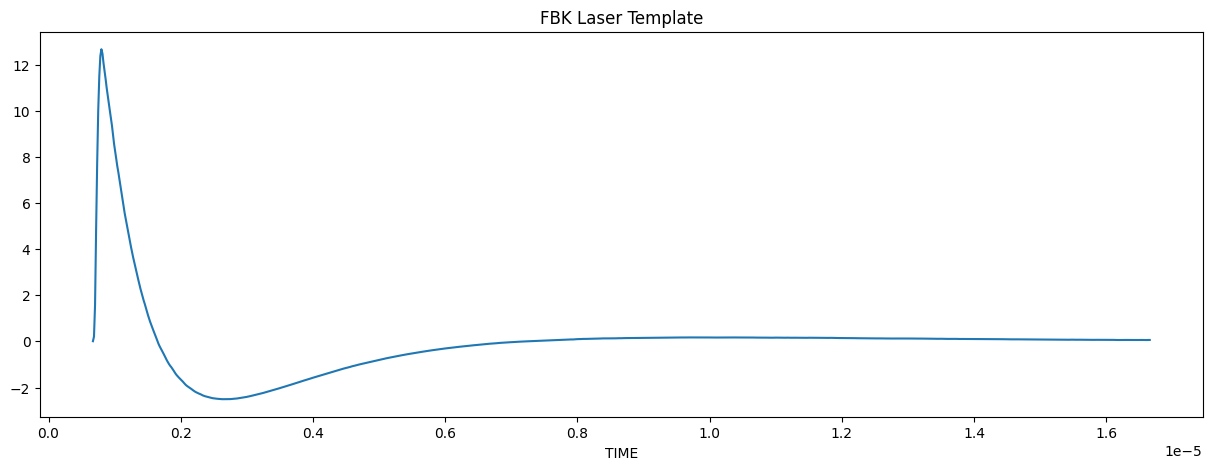

In [ ]:
export_ciemta_df = pd.DataFrame(ciemat_template_dict_list)
hpk_SPE_amp = export_ciemta_df[(export_ciemta_df["MODEL"] == "HPK") & (export_ciemta_df["TYPE"] == "SPE")]["AMP"].groupby(export_ciemta_df["OV"]).mean()
fbk_SPE_amp = export_ciemta_df[(export_ciemta_df["MODEL"] == "FBK") & (export_ciemta_df["TYPE"] == "SPE")]["AMP"].groupby(export_ciemta_df["OV"]).mean()

hpk_array = export_ciemta_df[(export_ciemta_df["TYPE"] == "LASER")*(export_ciemta_df["MODEL"] == "HPK")*(export_ciemta_df["OV"] == 2)]
hpk_array = hpk_array.explode(["ADC","TIME"])
hpk_array = hpk_array[42:1042]
hpk_array["ADC"] = hpk_array["ADC"]*hpk_SPE_amp[2]/np.max(hpk_array["AMP"])
hpk_array.plot(x="TIME", y="ADC", figsize=(15,5), legend=False, title="HPK Laser Template")

fbk_array = export_ciemta_df[(export_ciemta_df["TYPE"] == "LASER")*(export_ciemta_df["MODEL"] == "FBK")*(export_ciemta_df["OV"] == 2)]
fbk_array = fbk_array.explode(["ADC","TIME"])
fbk_array = fbk_array[42:1042]
fbk_array["ADC"] = fbk_array["ADC"]*fbk_SPE_amp[2]/np.max(fbk_array["AMP"])
fbk_array.plot(x="TIME", y="ADC", figsize=(15,5), legend=False, title="FBK Laser Template")

def export_df_array_to_txt(df_array, folder, name):
    with open(folder+name+".txt", "w") as f:
        for index, row in df_array.iterrows():
            f.write(str(row["ADC"])+"\n")
    return 0
export_df_array_to_txt(hpk_array, "../template/", "HPK_SPE_CAEN_45%PDE")
export_df_array_to_txt(fbk_array, "../template/", "FBK_SPE_CAEN_45%PDE")
